## 1、导入相关包

In [1]:
import os
# 数据科学包
import random                      # 随机切分数据集
import numpy as np                 # 常用数据科学包
from PIL import Image              # 图像读取
import matplotlib.pyplot as plt    # 代码中快速验证
import cv2                         # 图像包

# 深度学习包
import paddle
import paddle.vision.transforms as tf      # 数据增强
from paddle.io import Dataset, DataLoader  # 定义数据集
import paddle.nn as nn                     # 网络

## 2、准备数据集

解压数据集

In [2]:
if not os.path.exists('data/cat_12_train'):
    !unzip data/cat_12_train.zip
if not os.path.exists('data/cat_12_test'):
    !unzip data/cat_12_test.zip

划分数据集

In [3]:
train_ratio = 0.8  # 训练集占0.8，验证集占0.2

train_paths, train_labels = [], []
valid_paths, valid_labels = [], []
with open('data/train_list.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if random.uniform(0, 1) < train_ratio:
            train_paths.append('data/' + line.split('	')[0])
            label = line.split('	')[1]
            train_labels.append(int(line.split('	')[1]))
        else:
            valid_paths.append('data/' + line.split('	')[0])
            valid_labels.append(int(line.split('	')[1]))

定义数据集

In [4]:
# 定义训练数据集
class TrainData(Dataset):
    def __init__(self, train_paths, train_labels):
        super().__init__()
        self.train_paths = train_paths
        self.train_labels = train_labels
        self.color_jitter = tf.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
        self.normalize = tf.Normalize(mean=0, std=1)
        self.random_crop = tf.RandomCrop(96, pad_if_needed=True)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = self.train_paths[index]
        # Height Weight Channel
        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # single channel copies
        
        image = cv2.resize(image.transpose((1, 2, 0)), (96, 96)).transpose([2, 0, 1])
        
        # 图像增广
        features = self.color_jitter(image.transpose([1, 2, 0]))
        features = self.random_crop(features)
        features = self.normalize(features.transpose([2, 0, 1])).astype(np.float32)

        # 读取标签
        labels = self.train_labels[index]

        return features, labels
    
    def __len__(self):
        return len(self.train_paths)
    
# 定义验证数据集
class ValidData(Dataset):
    def __init__(self, valid_paths, valid_labels):
        super().__init__()
        self.valid_paths = valid_paths
        self.valid_labels = valid_labels
        self.normalize = tf.Normalize(mean=0, std=1)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = self.valid_paths[index]

        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # single channel copies
        
        # 图像变换
        features = cv2.resize(image.transpose([1, 2, 0]), (96, 96)).transpose([2, 0, 1]).astype(np.float32)
        features = self.normalize(features)

        # 读取标签
        labels = self.valid_labels[index]

        return features, labels
    
    def __len__(self):
        return len(self.valid_paths)

查看对图像进行的增广变换


label: 11



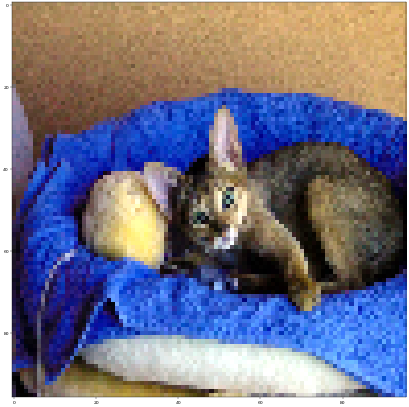

In [5]:
train_data = TrainData(train_paths, train_labels)
valid_data = TrainData(valid_paths, valid_labels)
img, labels = train_data.__getitem__(98)
print('label: '+str(label))
plt.figure(dpi=32,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))
plt.show()

## 3、准备网络模型

生成器

In [6]:
class Generator(nn.Layer):
    def __init__(self, nz=100):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2DTranspose(nz, 1024, kernel_size=[4, 4], data_format='NCHW'),
            nn.BatchNorm2D(1024),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2DTranspose(1024, 512, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(512),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2DTranspose(512, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(128),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2DTranspose(128, 3, kernel_size=[5, 5], stride=[3, 3], padding=1, data_format='NCHW'),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

gen_net = Generator()
print(gen_net)


W0112 21:27:47.842664  2692 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0112 21:27:47.843894  2692 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


Generator(
  (layer1): Sequential(
    (0): Conv2DTranspose(100, 1024, kernel_size=[4, 4], data_format=NCHW)
    (1): BatchNorm2D(num_features=1024, momentum=0.9, epsilon=1e-05)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2DTranspose(1024, 512, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2DTranspose(512, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2DTranspose(128, 3, kernel_size=[5, 5], stride=[3, 3], padding=1, data_format=NCHW)
    (1): Tanh()
  )
)


判别器

In [7]:
class Discriminator(nn.Layer):
    def __init__(self, num_classes=1):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=[5, 5], stride=[3, 3], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(64),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(128),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(256),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2D(256, 512, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(512),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.layer5 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*4*4, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
    
dis_net = Discriminator()
print(dis_net)

Discriminator(
  (layer1): Sequential(
    (0): Conv2D(3, 64, kernel_size=[5, 5], stride=[3, 3], padding=1, data_format=NCHW)
    (1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer4): Sequential(
    (0): Conv2D(256, 512, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer5): Sequential(
    (0): Flatten()
    (1): Linear(in_features=8192, out_features=

建立DCGAN模型

In [12]:
# 可视化
from visualdl import LogWriter
logwriter = LogWriter(logdir='./visualdl/gan')

class DCGAN:
    def __init__(self, lr=0.0002, batch_size=64, episodes=50):
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.optim_for_gen = paddle.optimizer.Adam(lr, parameters=self.generator.parameters(), beta1=0.5)
        self.optim_for_dis = paddle.optimizer.Adam(lr, parameters=self.discriminator.parameters(), beta1=0.5)
        self.loss_for_gen = nn.BCELoss()
        self.loss_for_dis = nn.BCELoss()
        self.true_label = 1
        self.false_label = 0
        self.batch_size = batch_size
        self.episodes = episodes
        self.label = paddle.to_tensor([1]*self.batch_size)

    def load_data(self, root='./data/cat_12_train'):
        transform = tf.Compose([
            tf.Resize((96, 96)),
            tf.ToTensor(),
            tf.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        dataset = paddle.vision.datasets.ImageFolder(root, transform=transform)
        self.data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def train(self):
        for epoch in range(0, self.episodes):
            for i, img in enumerate(self.data_loader):
                # train discriminator
                # 使用真实数据集
                img = img[0]
                self.optim_for_dis.clear_grad()
                output = nn.functional.sigmoid(self.discriminator(img)).squeeze()
                self.label = paddle.to_tensor([self.true_label]*img.shape[0], dtype='float32')
                
                err1 = self.loss_for_dis(output, self.label)
                err1.backward()

                # 使用生成数据集
                self.label = paddle.to_tensor([self.false_label]*img.shape[0], dtype='float32')
                noise = paddle.randn((img.shape[0], 100, 1, 1))
                fake = self.generator(noise)
                output = nn.functional.sigmoid(self.discriminator(fake.detach())).squeeze()
                err2 = self.loss_for_dis(output, self.label)
                err2.backward()
                err = err1+err2
                self.optim_for_dis.step()


                # train generator
                self.optim_for_gen.clear_grad()
                self.label = paddle.to_tensor([self.true_label]*img.shape[0], dtype='float32')
                output = nn.functional.sigmoid(self.discriminator(fake)).squeeze()
                err3 = self.loss_for_gen(output, self.label)
                err3.backward()
                self.optim_for_gen.step()


                if i%50==0:
                    print('epoch/Epoch {}/{} iter/Iter {}/{} lossD{:.4f}, lossG{:.4f}'.format(epoch, self.episodes-1, i+1, len(self.data_loader), err.item(), err3.item()))
                    logwriter.add_scalar("generator_loss", value=err3.item(), step=i+epoch*(self.batch_size))
                    logwriter.add_scalar("discriminator_loss", value=err.item(), step=i+epoch*(self.batch_size))
                
                if epoch%5 == 0:
                    paddle.save(self.generator.state_dict(), os.path.join('model', 'gan', 'generator{}.pdmodel'.format(str(epoch).zfill(4))))
                    paddle.save(self.discriminator.state_dict(), os.path.join('model', 'gan', 'discriminator{}.pdmodel'.format(str(epoch).zfill(4))))
            
        
        paddle.save(self.generator.state_dict(), os.path.join('model', 'gan', 'generator.pdmodel'))
        paddle.save(self.discriminator.state_dict(), os.path.join('model', 'gan', 'discriminator.pdmodel'))
    

    def lode_model(self, gen_path, dis_path):
        gen_path_dict = paddle.load(gen_path)
        self.generator.set_state_dict(gen_path_dict)
        dis_path_dict = paddle.load(dis_path)
        self.discriminator.set_state_dict(dis_path_dict)

载入预训练模型

In [14]:
dcgan = DCGAN()
dcgan.lode_model("pretrained_models/dcgan/generator.pdmodel","pretrained_models/dcgan/discriminator.pdmodel")

## 4、模型训练

In [15]:
# 设置GPU环境，如果没有GPU则设置为CPU
if paddle.is_compiled_with_cuda() and paddle.get_device() != 'cpu':
    paddle.set_device('gpu:0')
    print("Using GPU.")
else:
    paddle.set_device('cpu')
    print("Using CPU.")

dcgan.load_data()
dcgan.train()

Using GPU.


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


epoch/Epoch 0/49 iter/Iter 1/34 lossD1.0765, lossG1.7867
epoch/Epoch 1/49 iter/Iter 1/34 lossD1.2977, lossG1.6492
epoch/Epoch 2/49 iter/Iter 1/34 lossD1.1568, lossG1.5568
epoch/Epoch 3/49 iter/Iter 1/34 lossD1.1726, lossG1.6485
epoch/Epoch 4/49 iter/Iter 1/34 lossD1.1125, lossG1.6982
epoch/Epoch 5/49 iter/Iter 1/34 lossD1.1174, lossG1.5682
epoch/Epoch 6/49 iter/Iter 1/34 lossD1.1178, lossG1.5233
epoch/Epoch 7/49 iter/Iter 1/34 lossD1.3691, lossG1.2656
epoch/Epoch 8/49 iter/Iter 1/34 lossD1.2683, lossG1.0885
epoch/Epoch 9/49 iter/Iter 1/34 lossD1.1799, lossG1.2526
epoch/Epoch 10/49 iter/Iter 1/34 lossD1.0975, lossG1.8775
epoch/Epoch 11/49 iter/Iter 1/34 lossD1.1180, lossG1.4521
epoch/Epoch 12/49 iter/Iter 1/34 lossD1.2990, lossG1.3064
epoch/Epoch 13/49 iter/Iter 1/34 lossD1.1099, lossG1.8060
epoch/Epoch 14/49 iter/Iter 1/34 lossD1.0752, lossG1.4978
epoch/Epoch 15/49 iter/Iter 1/34 lossD1.0380, lossG2.0627
epoch/Epoch 16/49 iter/Iter 1/34 lossD1.0375, lossG1.7206
epoch/Epoch 17/49 iter/I

## 5、模型测试

生成器

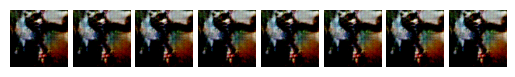

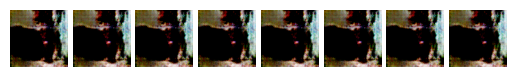

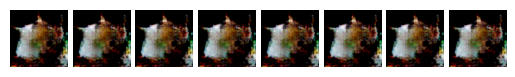

In [16]:
generator = Generator()
# 模型载入
gen_path_dict = paddle.load('./model/gan/generator.pdmodel')
generator.set_state_dict(gen_path_dict)

for i in range(3):
    # 噪声生成
    noise = paddle.randn((100, 1, 1))
    const_n = []
    for m in range(8):
        noise2 = paddle.clone(noise)
        noise2[i] = (m + 1) / 8
        const_n.append(noise2)
    const_n = paddle.to_tensor(np.array(const_n).astype('float32'))                         
    fake = generator(const_n)

    for i in range(8):
        image = fake[i].transpose([1, 2, 0])
        plt.subplot(1, 8, i + 1)
        plt.imshow(np.clip(image, 0 ,1), vmin=-1, vmax=1)
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.show()

修改判别器输出，将其调整为分类器

In [22]:
classifier = Discriminator(num_classes=12)
# 模型载入
dis_path_dict = paddle.load('model/gan/final.pdparams')
classifier.set_state_dict(dis_path_dict)

([], [])

测试分类器

直接测试

In [23]:
transform = tf.Compose([
            tf.Resize((96, 96)),
            tf.ToTensor(),
            tf.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

pres = []
for path, label in zip(valid_paths, valid_labels):
    img = Image.open(path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img = transform(img).unsqueeze(0)
    pre_p = classifier(img).cpu().numpy().flatten()
    pre = np.argmax(pre_p)
    pres.append(pre==label)

print("Accuracy: {}".format(pres.count(True) / len(pres)))

Accuracy: 0.8571428571428571


模型微调

In [24]:
epochs = 50
batch_size = 32

# 设置GPU环境，如果没有GPU则设置为CPU
if paddle.is_compiled_with_cuda() and paddle.get_device() != 'cpu':
    paddle.set_device('gpu:0')
    print("Using GPU.")
else:
    paddle.set_device('cpu')
    print("Using CPU.")

# 定义数据迭代器
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=False)

# 定义优化器
opt = paddle.optimizer.Adam(learning_rate=1e-4, parameters=classifier.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-4))

# 定义损失函数
loss_fn = paddle.nn.CrossEntropyLoss()

# 用于测量准确率的评价指标对象
metric =  paddle.metric.Accuracy()

# 定义 EarlyStopping 回调函数
callback = paddle.callbacks.EarlyStopping(monitor='acc', patience=5, mode='max', verbose=1)
# 定义 ModelCheckpoint 回调函数
checkpoint_callback = paddle.callbacks.ModelCheckpoint(save_dir='./model/gan', save_freq=2)
# 设置 visualdl 路径
log_dir = './visualdl/gan'
visual_callback = paddle.callbacks.VisualDL(log_dir=log_dir)

# 使用高层API进行训练
model = paddle.Model(classifier) # 用 Model 封装
# 模型配置
model.prepare(opt, loss_fn, metric)
# 模型训练
model.fit(train_dataloader,
          valid_dataloader,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1,
          callbacks= [callback, checkpoint_callback, visual_callback])

Using GPU.
The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/50
step 54/54 [==============================] - loss: 0.3730 - acc: 0.9540 - 111ms/step          
save checkpoint at /home/aistudio/model/gan/0
Eval begin...
step 14/14 [==============================] - loss: 0.2653 - acc: 0.9524 - 120ms/step          
Eval samples: 441
Epoch 2/50


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 54/54 [==============================] - loss: 0.0268 - acc: 0.9965 - 110ms/step          
Eval begin...
step 14/14 [==============================] - loss: 0.1614 - acc: 0.9546 - 116ms/step          
Eval samples: 441
Epoch 3/50


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 54/54 [==============================] - loss: 0.0241 - acc: 0.9994 - 109ms/step          
save checkpoint at /home/aistudio/model/gan/2
Eval begin...
step 14/14 [==============================] - loss: 0.0135 - acc: 0.9546 - 113ms/step          
Eval samples: 441
Epoch 4/50


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 54/54 [==============================] - loss: 0.0167 - acc: 1.0000 - 109ms/step          
Eval begin...
step 14/14 [==============================] - loss: 0.0142 - acc: 0.9524 - 121ms/step          
Eval samples: 441
Epoch 5/50


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 54/54 [==============================] - loss: 0.0053 - acc: 1.0000 - 109ms/step          
save checkpoint at /home/aistudio/model/gan/4
Eval begin...
step 14/14 [==============================] - loss: 0.1897 - acc: 0.9524 - 114ms/step          
Eval samples: 441
Epoch 6/50


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 54/54 [==============================] - loss: 0.0107 - acc: 1.0000 - 106ms/step          
Eval begin...
step 14/14 [==============================] - loss: 0.2264 - acc: 0.9524 - 121ms/step          
Eval samples: 441
Epoch 7/50


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step 54/54 [==============================] - loss: 0.0055 - acc: 1.0000 - 108ms/step          
save checkpoint at /home/aistudio/model/gan/6
Eval begin...
step 14/14 [==============================] - loss: 0.1213 - acc: 0.9456 - 117ms/step          
Eval samples: 441
Epoch 7: Early stopping.
save checkpoint at /home/aistudio/model/gan/final
